In [1]:
import tensorflow as tf

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
print(tf.__version__)

1.3.0


In [5]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data",one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


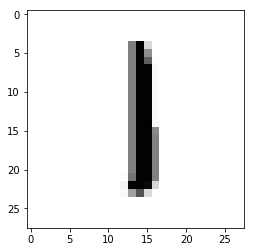

In [6]:
plt.imshow(mnist.train.images[12].reshape(28,28),cmap='Greys')

## Leaky Relu
#### Leaky ReLUs allow a small, non-zero gradient when the unit is not active insteaed of 0
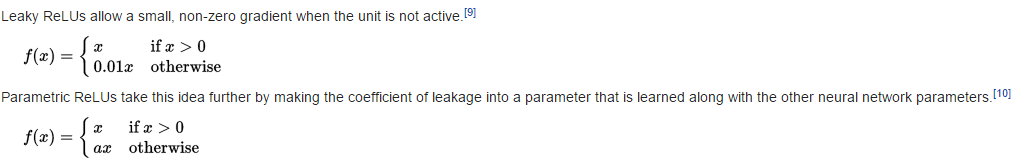

## units in tf.layers.dense:

### means that how many output nodes of dense layer should be returned.
Because the fully connected layer(dense layer) should consist of input and output.
Then , the mean of dimensionality of the output space could be translated to the number of ouput nodes.
if the units = 1 , it means all the input nodes connected to one output nodes
in inception v3 or other classifier model, we could found the units of dense layer always be the classifier number.

In [17]:
# Generator create fake things. We will train Generator network so that it generates images that the discriminator finds difficult to classify as fake
def generator(z,reuse=None): 
    with tf.variable_scope('gen',reuse=reuse):
        # hidden 1 will take input automatically decide the number of nodes in input layer and no. of nodes in output layer is
        # units, units are the number of nodes in the next layer
        hidden1 = tf.layers.dense(inputs=z,units=128,activation=tf.nn.leaky_relu)
        hidden2 = tf.layers.dense(inputs=hidden1,units=128,activation=tf.nn.leaky_relu)
        
        output = tf.layers.dense(hidden2,units=784,activation=tf.nn.tanh)
        
        return output

In [20]:
def discriminator(X,reuse=None):
    with tf.variable_scope('dis',reuse=reuse):
        hidden1 = tf.layers.dense(inputs=X,units=128,activation=tf.nn.leaky_relu)
        hidden2 = tf.layers.dense(inputs=hidden1,units=128,activation=tf.nn.leaky_relu)
        
        logits = tf.layers.dense(hidden2,units=1)
        output = tf.sigmoid(logits)
        
        return output,logits

In [10]:
real_images = tf.placeholder(tf.float32,[None,784])
z = tf.placeholder(tf.float32,shape=[None,100])

In [18]:
# G is the image generated by the Generator Neural Network
G = generator(z)

In [21]:
D_output_real, D_logits_real = discriminator(real_images)

In [22]:
# reuse  = True here means use the same weights and bias variables that were called by above discriminator function
# if reuse = None it will give error because the method will try to create some new variables with same name (weights and biases) which already exist
D_output_fake , D_logits_fake= discriminator(G,reuse=True)

In [23]:
# losses 
def loss_func(logits_in,labels_in):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_in,
                                                                 labels=labels_in))

In [30]:
# tf.ones_like is same as tf.ones but in tf.ones we have to provide the shape where as in tf.ones_like we don't have to

D_real_loss = loss_func(D_logits_real,tf.ones_like(D_logits_real))

D_fake_loss = loss_func(D_logits_fake,tf.zeros_like(D_logits_real))

D_loss = D_real_loss + D_fake_loss

In [26]:
G_loss = loss_func(D_logits_fake,tf.ones_like(D_logits_fake))

In [27]:
learning_rate = 0.001

In [81]:
tvars = tf.trainable_variables()

d_vars = [var for var in tvars if 'dis' in var.name]
g_vars = [var for var in tvars if 'gen' in var.name]

In [73]:
D_trainer = tf.train.AdamOptimizer(learning_rate).minimize(D_loss,var_list=d_vars)

In [32]:
G_trainer = tf.train.AdamOptimizer(learning_rate).minimize(G_loss,var_list=g_vars)

In [33]:
d_vars # variables (weights and biases ) of Discriminator

[<tf.Variable 'dis/dense/kernel:0' shape=(784, 128) dtype=float32_ref>,
 <tf.Variable 'dis/dense/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'dis/dense_1/kernel:0' shape=(128, 128) dtype=float32_ref>,
 <tf.Variable 'dis/dense_1/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'dis/dense_2/kernel:0' shape=(128, 1) dtype=float32_ref>,
 <tf.Variable 'dis/dense_2/bias:0' shape=(1,) dtype=float32_ref>]

In [34]:
batch_size = 100

In [44]:
epochs = 500

In [36]:
init = tf.global_variables_initializer()

In [37]:
samples = [] # list of images that were created after every epoch. it is for visualizing purpose
saver=tf.train.Saver()

In [45]:
with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(epochs):
        # 
        num_batches = mnist.train.num_examples // batch_size  # // means classic division(integer division) not true (float) division 
        
        for i in range(num_batches):
            batch = mnist.train.next_batch(batch_size)
            
            batch_images = batch[0].reshape((batch_size,784))
            
            batch_images = batch_images *2 -1 # *2-1 is for making this variable a linear function
            
            batch_z = np.random.uniform(-1,1,size=(batch_size,100))  # fake images which will be given to generator
            # z is the placeholder which is given to Generator model generator(z) which produces a fake image of 28x28 pixels i.e. the 784 values stored in G
            _= sess.run(D_trainer,feed_dict={real_images:batch_images,z:batch_z}) # z is basically the fake images generated by the generator
            _= sess.run(G_trainer,feed_dict={z:batch_z})
        # after the model is trained we are visualizing the model output (Generator) by giving a fake image to generator
        print("On Epoch{}".format(epoch))
        
        sample_z = np.random.uniform(-1,1,size=(1,100))
        gen_sample = sess.run(generator(z,reuse=True),feed_dict={z:sample_z})
        
        samples.append(gen_sample) # a single image generated by the generator
    saver.save(sess,"./gan_model")
        

On Epoch0
On Epoch1
On Epoch2
On Epoch3
On Epoch4
On Epoch5
On Epoch6
On Epoch7
On Epoch8
On Epoch9
On Epoch10
On Epoch11
On Epoch12
On Epoch13
On Epoch14
On Epoch15
On Epoch16
On Epoch17
On Epoch18
On Epoch19
On Epoch20
On Epoch21
On Epoch22
On Epoch23
On Epoch24
On Epoch25
On Epoch26
On Epoch27
On Epoch28
On Epoch29
On Epoch30
On Epoch31
On Epoch32
On Epoch33
On Epoch34
On Epoch35
On Epoch36
On Epoch37
On Epoch38
On Epoch39
On Epoch40
On Epoch41
On Epoch42
On Epoch43
On Epoch44
On Epoch45
On Epoch46
On Epoch47
On Epoch48
On Epoch49
On Epoch50
On Epoch51
On Epoch52
On Epoch53
On Epoch54
On Epoch55
On Epoch56
On Epoch57
On Epoch58
On Epoch59
On Epoch60
On Epoch61
On Epoch62
On Epoch63
On Epoch64
On Epoch65
On Epoch66
On Epoch67
On Epoch68
On Epoch69
On Epoch70
On Epoch71
On Epoch72
On Epoch73
On Epoch74
On Epoch75
On Epoch76
On Epoch77
On Epoch78
On Epoch79
On Epoch80
On Epoch81
On Epoch82
On Epoch83
On Epoch84
On Epoch85
On Epoch86
On Epoch87
On Epoch88
On Epoch89
On Epoch90
On Epoch9

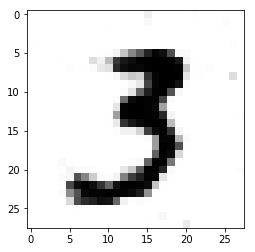

In [77]:
plt.imshow(samples[499].reshape(28,28),cmap='Greys')